📊 Final Results:

---

📚 Total books processed: 388

✅ Successful downloads: 336

❌ Failed downloads: 52

📈 Success rate: 86.6%


In [1]:
from pathlib import Path

audio_save_path = Path("../data/audio/raw/")
text_save_path = Path("../data/text/pdf/")

In [2]:
audio_dirs = [d for d in audio_save_path.iterdir() if d.is_dir()]
text_files = text_save_path.glob("**/*.pdf")

text_files = [f for f in text_files if f.is_file()]
audio_dirs = [d for d in audio_dirs if d.is_dir()]

len(text_files), len(audio_dirs), text_files[:5], audio_dirs[:5]

(387,
 331,
 [PosixPath('../data/text/pdf/sach-den-ve-tinh-than-doanh-nhan.pdf'),
  PosixPath('../data/text/pdf/ping-hanh-trinh-ra-bien-lon.pdf'),
  PosixPath('../data/text/pdf/suc-manh-cua-su-tu-te.pdf'),
  PosixPath('../data/text/pdf/chu-be-rac-roi.pdf'),
  PosixPath('../data/text/pdf/chiec-la-cuoi-cung.pdf')],
 [PosixPath('../data/audio/raw/suc-manh-cua-su-khich-le'),
  PosixPath('../data/audio/raw/bi-mat-ho-ca-than'),
  PosixPath('../data/audio/raw/khuc-nam-ai'),
  PosixPath('../data/audio/raw/bi-mat-cua-vua-solomon'),
  PosixPath('../data/audio/raw/binh-minh-va-hoang-hon')])

In [3]:
def get_dir_size(path: Path, print_size: bool = False) -> int:
  size = sum(f.stat().st_size for f in path.rglob("*") if f.is_file())
  if print_size:
    print(f"Directory: {path}, Size: {size / (1024 * 1024):.2f} MB")
  return size


(
  get_dir_size(audio_save_path, print_size=True),
  get_dir_size(text_save_path, print_size=True),
)

Directory: ../data/audio/raw, Size: 55436.77 MB
Directory: ../data/text/pdf, Size: 638.70 MB


(58129662029, 669720595)

In [4]:
def matching_audio_text(text_files, audio_dirs, remove_empty_dirs=False):
  matched_pairs = []
  text_files = sorted(text_files, key=lambda f: f.stem)
  audio_dirs = sorted(audio_dirs, key=lambda d: d.stem)

  i_text, i_audio = 0, 0
  while i_text < len(text_files) and i_audio < len(audio_dirs):
    text_file = text_files[i_text]
    audio_dir = audio_dirs[i_audio]

    if text_file.stem == audio_dir.stem:
      if get_dir_size(audio_dir) == 0:
        if remove_empty_dirs:
          print(f"Removing empty directory: {audio_dir}")
          # Remove the text file if it matches an empty audio directory
          text_file.unlink(missing_ok=True)
          audio_dir.rmdir(missing_ok=True)  # Remove the empty audio directory
        else:
          print(f"Empty directory found: {audio_dir}, move it to unqualified directory")
          text_file.rename(text_save_path.parent / "unqualified" / text_file.name)
          audio_dir.rename(audio_save_path.parent / "unqualified" / audio_dir.name)
      else:
        matched_pairs.append((text_file, audio_dir))
      i_text += 1
      i_audio += 1
    elif text_file.stem < audio_dir.stem:
      text_file.rename(text_save_path.parent / "unqualified" / text_file.name)
      i_text += 1
    else:
      audio_dir.rename(audio_save_path.parent / "unqualified" / audio_dir.name)
      i_audio += 1

  print(f"Matched pairs: {len(matched_pairs)}")
  return matched_pairs


matched_pairs = matching_audio_text(text_files, audio_dirs, remove_empty_dirs=False)

Matched pairs: 331


In [5]:
matched_pairs[:5]

[(PosixPath('../data/text/pdf/10-bai-hoc-tren-chiec-khan-an.pdf'),
  PosixPath('../data/audio/raw/10-bai-hoc-tren-chiec-khan-an')),
 (PosixPath('../data/text/pdf/10-bi-quyet-thanh-cong-cua-nhung-dien-gia-mc-tai-nang-nhat-the-gioi.pdf'),
  PosixPath('../data/audio/raw/10-bi-quyet-thanh-cong-cua-nhung-dien-gia-mc-tai-nang-nhat-the-gioi')),
 (PosixPath('../data/text/pdf/10-dieu-khac-biet-nhat-giua-ke-giau-va-nguoi-ngheo.pdf'),
  PosixPath('../data/audio/raw/10-dieu-khac-biet-nhat-giua-ke-giau-va-nguoi-ngheo')),
 (PosixPath('../data/text/pdf/10-dieu-tao-nen-so-phan.pdf'),
  PosixPath('../data/audio/raw/10-dieu-tao-nen-so-phan')),
 (PosixPath('../data/text/pdf/10-nghich-ly-cuoc-song.pdf'),
  PosixPath('../data/audio/raw/10-nghich-ly-cuoc-song'))]

In [6]:
import pandas as pd
from typing import List, Tuple
from pathlib import Path
from tts_data_pipeline import Book

In [7]:
def update_metadata(
  old_df: pd.DataFrame,
  matched_pairs: List[Tuple[Path, Path]],
  name_new_df: str = "after_download_metadata",
  save_json: bool = True,
  save_csv: bool = True,
) -> pd.DataFrame:
  """
  Update metadata for matched text/audio pairs with optimized performance.

  Args:
      old_df: Original metadata DataFrame
      matched_pairs: List of (text_file, audio_dir) tuples
      name_new_df: Name for output CSV file
      save_json: Whether to save individual JSON files
      save_csv: Whether to save consolidated CSV

  Returns:
      Updated DataFrame with new metadata
  """
  name_to_row = {row["name"]: row for _, row in old_df.iterrows()}
  updated_records = []
  missing_names = []

  # Create output directory if saving JSON files
  if save_json:
    json_output_dir = Path("../data/metadata/book")
    json_output_dir.mkdir(parents=True, exist_ok=True)

  for text_file, audio_dir in matched_pairs:
    name = text_file.stem

    if name not in name_to_row:
      missing_names.append(name)
      continue

    row_dict = name_to_row[name]
    book = Book.from_dict(row_dict)

    # Update paths and sizes
    book.update_paths(
      audio_path=audio_dir,
      text_path=text_file,
    )
    book.update_size(
      audio_size=get_dir_size(audio_dir),
      text_size=text_file.stat().st_size,
    )

    # Save JSON if requested
    if save_json:
      json_path = json_output_dir / f"{name}.json"
      book.save_json(path=json_path)

    # Collect record for batch DataFrame creation
    updated_records.append(book.to_dict())

  # Report missing names at once
  if missing_names:
    print(
      f"Warning: No metadata found for {len(missing_names)} items: {missing_names[:5]}"
    )
    if len(missing_names) > 5:
      print(f"... and {len(missing_names) - 5} more")

  # Create DataFrame in one operation instead of repeated concatenation
  new_df = pd.DataFrame(updated_records, columns=old_df.columns)

  # Save CSV if requested
  if save_csv:
    csv_output_dir = Path("../data/metadata")
    csv_output_dir.mkdir(parents=True, exist_ok=True)
    csv_path = csv_output_dir / f"{name_new_df}.csv"
    new_df.to_csv(csv_path, index=False)

  return new_df

In [8]:
old_metadata_df = pd.read_csv("../data/metadata/able_download_metadata_less_5_hour.csv")
# old_metadata_df.head()

In [9]:
after_download_metadata_df = update_metadata(
  old_metadata_df, matched_pairs, save_json=False
)
after_download_metadata_df.head()

,id,name,text_path,audio_path,narrator,duration,author,text_url,audio_url,alignment_path,text_download_url,audio_download_url,sample_rate,quality,word_count,num_sentences,audio_size,text_size
0,a00985dd,10-bai-hoc-tren-chiec-khan-an,../data/text/pdf/10-bai-hoc-tren-chiec-khan-an...,../data/audio/raw/10-bai-hoc-tren-chiec-khan-an,"{'id': '5af6cbeb', 'name': 'Trần Huỳnh Phương ...",2.5039,Don Failla,['https://thuviensachpdf.com/10-bai-hoc-tren-c...,https://sachnoiviet.net/sach-noi/10-bai-hoc-tr...,NaN,https://cloud.thuviensachpdf.com/pdf/vi/10-bai...,['https://archive.org/download/10-bai-hoc-tren...,NaN,NaN,NaN,NaN,144734808,347556
1,2c0c221e,10-bi-quyet-thanh-cong-cua-nhung-dien-gia-mc-t...,../data/text/pdf/10-bi-quyet-thanh-cong-cua-nh...,../data/audio/raw/10-bi-quyet-thanh-cong-cua-n...,"[{'id': '047c61b1', 'name': 'Ái Hòa', 'dialect...",4.2244,Carmine Gallo,['https://thuviensachpdf.com/10-bi-quyet-thanh...,https://sachnoiviet.net/sach-noi/10-bi-quyet-t...,NaN,https://cloud.thuviensachpdf.com/pdf/vi/10-bi-...,['https://archive.org/download/10-bi-02/10-bi-...,NaN,NaN,NaN,NaN,121662956,1017767
2,a0c7d3cd,10-dieu-khac-biet-nhat-giua-ke-giau-va-nguoi-n...,../data/text/pdf/10-dieu-khac-biet-nhat-giua-k...,../data/audio/raw/10-dieu-khac-biet-nhat-giua-...,"{'id': '134c54b3', 'name': 'Trần Huỳnh Phương ...",2.0014,Keith Cameron Smith,['https://thuviensachpdf.com/10-dieu-khac-biet...,https://sachnoiviet.net/sach-noi/10-dieu-khac-...,NaN,https://cloud.thuviensachpdf.com/pdf/vi/10-die...,['https://archive.org/download/truyenngan_2019...,NaN,NaN,NaN,NaN,57600157,2764042
3,33797050,10-dieu-tao-nen-so-phan,../data/text/pdf/10-dieu-tao-nen-so-phan.pdf,../data/audio/raw/10-dieu-tao-nen-so-phan,"[{'id': '97bdf585', 'name': 'Ái Hòa', 'dialect...",3.7058,Maria Shriver,['https://thuviensachpdf.com/10-dieu-tao-nen-s...,https://sachnoiviet.net/sach-noi/10-dieu-tao-n...,NaN,https://cloud.thuviensachpdf.com/pdf/vi/10-die...,['https://archive.org/download/audiobook-10die...,NaN,NaN,NaN,NaN,98223048,464391
4,7685d9c3,10-nghich-ly-cuoc-song,../data/text/pdf/10-nghich-ly-cuoc-song.pdf,../data/audio/raw/10-nghich-ly-cuoc-song,"[{'id': '2b4c5c3b', 'name': 'Ái Hòa', 'dialect...",3.2611,Kent M. Keith Ph. D.,['https://thuviensachpdf.com/10-nghich-ly-cuoc...,https://sachnoiviet.net/sach-noi/10-nghich-ly-...,NaN,https://cloud.thuviensachpdf.com/pdf/vi/10-ngh...,['https://archive.org/download/truyenngan_2019...,NaN,NaN,NaN,NaN,89579482,308308


In [10]:
import ast

not_enough_part_book_name = []
for book in after_download_metadata_df.itertuples():
  audio_download_urls = ast.literal_eval(book.audio_download_url)
  audio_path = Path(book.audio_path)

  if not audio_path.exists():
    print(f"Audio path does not exist: {audio_path}")

  if len(audio_download_urls) != len(list(audio_path.glob("*.*"))):
    print(
      f"Mismatch in audio files for {book.name}: {len(audio_download_urls)} URLs vs {len(list(audio_path.glob('*.*')))} files"
    )
    not_enough_part_book_name.append(book.name)
    audio_path.rename(audio_path.parent.parent / "unqualified" / audio_path.name)
    book.text_path.rename(
      book.text_path.parent.parent / "unqualified" / book.text_path.name
    )

print(f"Length of metadata before filtering: {len(after_download_metadata_df)}")
after_download_metadata_df = after_download_metadata_df[
  ~after_download_metadata_df["name"].isin(not_enough_part_book_name)
]
print(f"Length of metadata after filtering: {len(after_download_metadata_df)}")

after_download_metadata_df.to_csv(
  "../data/metadata/after_download_metadata.csv", index=False
)

Length of metadata before filtering: 331
Length of metadata after filtering: 331


## Analysis of results:


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

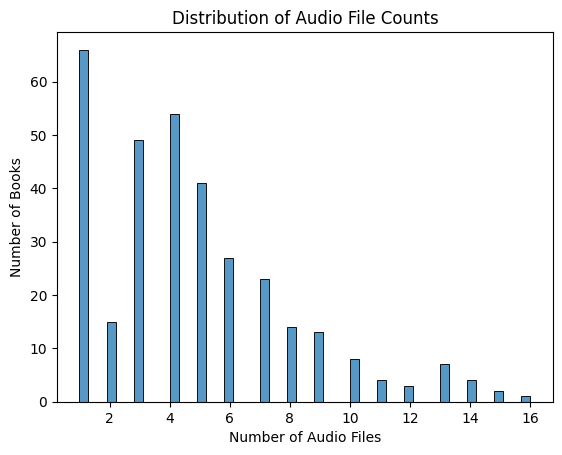

In [ ]:
# The histogram of audio file counts per book
audio_counts = after_download_metadata_df["audio_download_url"].apply(
  lambda x: len(ast.literal_eval(x))
)
sns.histplot(audio_counts, bins=50, edgecolor="black")
plt.xlabel("Number of Audio Files")
plt.ylabel("Number of Books")
plt.title("Distribution of Audio File Counts")
plt.show()

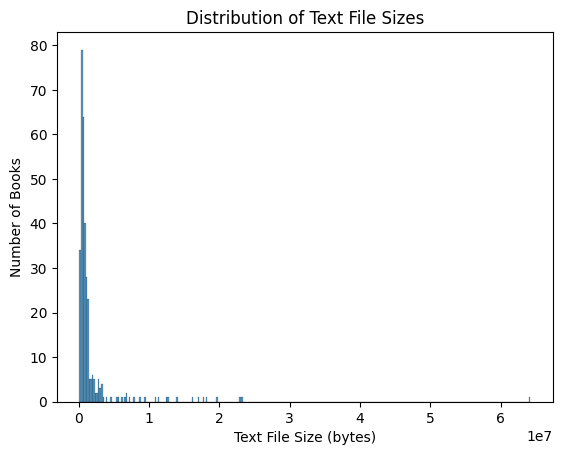

In [17]:
# The histogram of text file sizes
text_sizes = after_download_metadata_df["text_size"]
sns.histplot(text_sizes, edgecolor="black")
plt.xlabel("Text File Size (bytes)")
plt.ylabel("Number of Books")
plt.title("Distribution of Text File Sizes")
plt.show()

In [23]:
after_download_metadata_df.iloc[text_sizes.idxmax()]

id                                                             ffd019b4
name                                                    guong-kien-nhan
text_path                          ../data/text/pdf/guong-kien-nhan.pdf
audio_path                            ../data/audio/raw/guong-kien-nhan
narrator              {'id': '597d03e4', 'name': 'Đỗ Thụy', 'dialect...
duration                                                         4.1008
author                                                   Nguyễn Hiến Lê
text_url              ['https://thuviensachpdf.com/guong-kien-nhan',...
audio_url              https://sachnoiviet.net/sach-noi/guong-kien-nhan
alignment_path                                                      NaN
text_download_url     https://cloud.thuviensachpdf.com/pdf/vi/guong-...
audio_download_url    ['https://archive.org/download/guong-6/guong-1...
sample_rate                                                         NaN
quality                                                         

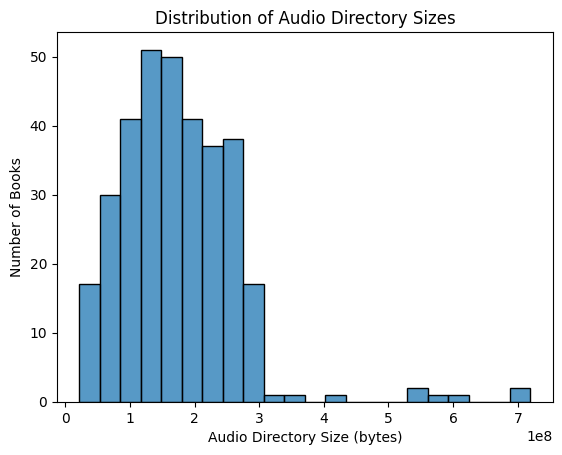

In [21]:
# The histogram of audio directory sizes
audio_sizes = after_download_metadata_df["audio_size"]
sns.histplot(audio_sizes, edgecolor="black")
plt.xlabel("Audio Directory Size (bytes)")
plt.ylabel("Number of Books")
plt.title("Distribution of Audio Directory Sizes")
plt.show()

In [ ]:
after_download_metadata_df.iloc[
  audio_sizes.idxmax()
]  # The book with the largest audio directory size is the book having the largest duration

id                                                             54717df0
name                                               cay-cam-ngot-cua-toi
text_path                     ../data/text/pdf/cay-cam-ngot-cua-toi.pdf
audio_path                       ../data/audio/raw/cay-cam-ngot-cua-toi
narrator              {'id': 'a304e68f', 'name': 'Phát Thanh Sóc Tră...
duration                                                         4.9997
author                                                       José Mauro
text_url              ['https://thuviensachpdf.com/cay-cam-ngot-cua-...
audio_url             https://sachnoiviet.net/sach-noi/cay-cam-ngot-...
alignment_path                                                      NaN
text_download_url     https://cloud.thuviensachpdf.com/pdf/vi/cay-ca...
audio_download_url    ['https://archive.org/download/cay-cam-06/cay-...
sample_rate                                                         NaN
quality                                                         

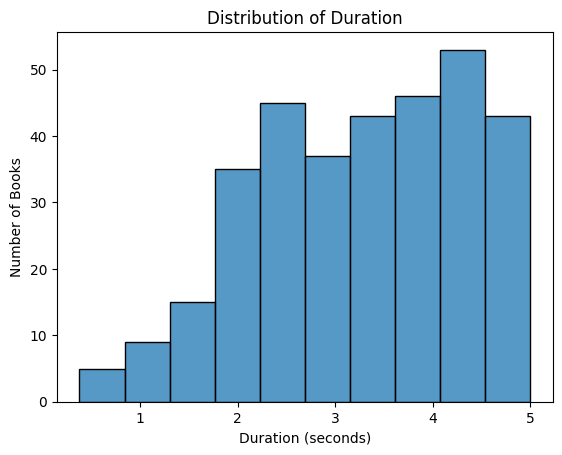

In [ ]:
# The histogram of duration
duration = after_download_metadata_df["duration"]
sns.histplot(duration, edgecolor="black")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Books") 
plt.title("Distribution of Duration")
plt.show()

In [25]:
duration.describe()

count    331.000000
mean       3.258792
std        1.078212
min        0.379200
25%        2.438900
50%        3.355000
75%        4.185800
max        4.999700
Name: duration, dtype: float64

In [27]:
duration.sum()

1078.6601